In [128]:
#FEM Mesh Generation, Data Input and Connectivity Matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
Z=np.array((pd.read_csv('z.csv'))) #read in data from a text file for initial pwp
Z=np.delete(Z, 0, axis=1)
w=1 #weights
n=4 #number of nodes per element
i_p=Z #initial elemental porewater pressure
col=Z.shape[1]+1 #number of column of nodes
row=Z.shape[1]+1 #number of row of nodes
a=0.5 #half element width
b=a #half element height
c=35 #coefficient of consolidation (ft^2/yr)
tot_el=(col-1)*(row-1) #total number of element
rg=np.array([1/np.sqrt(3),-1/np.sqrt(3),-1/np.sqrt(3),1/np.sqrt(3)])
sg=np.array([1/np.sqrt(3),1/np.sqrt(3),-1/np.sqrt(3),-1/np.sqrt(3)])
time=[0.1,0.3,1,3] #time period of interest
the=0.5 #Crank-Nicholson time-stepping

#Constructing global X-Y coordinates (mesh)
xglobal=np.array([0.0]*(row**2))
yglobal=np.array([0.0]*(col**2))
for i in range(1,row+1):
    for j in range(1,col+1):
        node=(j-1)*row+i
        xglobal[node-1]=(j-1)*2*a
        yglobal[node-1]=(i-1)*2*b
yglobal=-yglobal #convert to right hand coordinate system

#connectivity matrix
connect=np.array([0]*(tot_el*4)).reshape(tot_el,4)
el_num=0
for i in range(1,col):
    for j in range(1,row):
        el_num+=1
        connect[el_num-1,0]=i*row+j
        connect[el_num-1,1]=(i-1)*row+j
        connect[el_num-1,2]=(i-1)*row+j+1
        connect[el_num-1,3]=i*row+j+1

#Redistribute elemental initial porewater pressure to nodal initial powerwater pressure
i_p_nodal=np.array([0.0]*(col**2)).reshape(row,col)
i_p_nodal[i_p_nodal.shape[0]-1,0]=i_p[i_p_nodal.shape[0]-2,0]/4
for i in range(1,len(i_p_nodal[0])-1):
    i_p_nodal[i,0]=i_p[i-1,0]/4+i_p[i,0]/4
    i_p_nodal[len(i_p_nodal[0])-1,i]=i_p[len(i_p_nodal[0])-2,i]/4
    +i_p[len(i_p_nodal[0])-2,i-1]/4
    for j in range(1,len(i_p_nodal[0])-1):
        i_p_nodal[i,j]=i_p[i-1,j-1]/4+i_p[i-1,j]/4+i_p[i,j-1]/4+i_p[i,j]/4


In [35]:
#Construct B-matrix
def bmat(r,s,n,a,b):
    #interpolating function    
    h=[0.25*(1+r)*(1+s),0.25*(1-r)*(1+s),0.25*(1-r)*(1-s),0.25*(1+r)*(1-s)]
    #initialize empty B array
    B_diff=np.array([0.0]*(n*2)).reshape(2,n)
    #define derivative in r,s
    dhr=[0.25*(1+s),-0.25*(1+s),-0.25*(1-s),0.25*(1-s)]
    dhs=[0.25*(1+r),0.25*(1-r),-0.25*(1-r),-0.25*(1+r)]
    #define derivative in x,y
    dhx=[(1/a)*dhr[0],(1/a)*dhr[1],(1/a)*dhr[2],(1/a)*dhr[3]]
    dhy=[(1/b)*dhs[0],(1/b)*dhs[1],(1/b)*dhs[2],(1/b)*dhs[3]]
    #B-matrix component
    for i in range(4):
        B_diff[0,i]=dhx[i]
        B_diff[1,i]=dhy[i]
    return B_diff

In [54]:
#assemble global K and global Q matrix
sz=col*row #number of element per row and column for 1 DOF per node
#initialize empty global k matrix
k_g=np.array([0.0]*(sz**2)).reshape(sz,sz)  #initialize global k matrix
q_g=np.array([0.0]*(sz**2)).reshape(sz,sz) #initialize global q matrix
xlocal=np.array([0]*(n)) #assigining local x-coordinates
i_p_nodal=i_p_nodal.reshape(col*row,1)
for k in range(tot_el):
    k_e=np.array([0]*(n**2)).reshape(n,n)   #initialize elemental k matrix
    q_e=np.array([0]*(n**2)).reshape(n,n)   #initialize elemental q matrix
    for i in range(len(rg)):
        for j in range(len(sg)):
            r=rg[i]
            s=sg[j]
            h=[0.25*(1+r)*(1+s),0.25*(1-r)*(1+s),0.25*(1-r)*(1-s),0.25*(1+r)*(1-s)]
            h=np.array((h)).reshape(1,4)
            dhr=[0.25*(1+s),-0.25*(1+s),-0.25*(1-s),0.25*(1-s)]
            dhs=[0.25*(1+r),0.25*(1-r),-0.25*(1-r),-0.25*(1+r)]
            for y in range(n):
                xlocal[y]=xglobal[connect[k,y]-1]
            x_gauss=np.matmul(h,xlocal.reshape(4,1)) #elemental thickness
            t=x_gauss*2*np.pi #elemental thickness
            #assembly of k_e & q_e
            k_e=k_e+c*a*b*t*np.matmul(np.transpose(bmat(r,s,n,a,b)),bmat(r,s,n,a,b))
            q_e=q_e+a*b*t*np.matmul(np.transpose(h),h)
    #assemble k_g & q_g
    for p in range(4):
        for o in range(4):
            k_g[connect[k,p]-1,connect[k,o]-1]=k_g[connect[k,p]-1,connect[k,o]-1]+k_e[p,o]
            q_g[connect[k,p]-1,connect[k,o]-1]=q_g[connect[k,p]-1,connect[k,o]-1]+q_e[p,o]


In [92]:
# initilize initial condition and converting to column vector with its respective nodes
col_i_p_nodal=np.array([0.0]*(col**2)).reshape(col**2,1)
for j in range(col):
    for i in range(row):
        col_i_p_nodal[j*col+i]=i_p_nodal[row*i+j]

#time updating loop
for i in range(len(time)):
    #initialize empty array (left hand side)
    load_vec=np.array([0.0]*(sz**2)).reshape(sz,sz)
    #initialize empty array (right hand side-coefficient of target variable)
    time_for_coeff=np.array([0.0]*(sz**2)).reshape(sz,sz)
    for i in range(len(t)):
    load_vec=np.matmul(((1/time[i])*q_g-((1-the)*k_g)),col_i_p_nodal)
    time_for_coeff=((the*k_g)+((1/time[i])*q_g))
    p_t=np.linalg.solve(time_for_coeff,load_vec) #solving for target variable
    for j in range(col): #impose boundary condition after every timestep
        p_t[col*j]=0.0
        p_t[col*(col-1)+j]=0.0
    col_i_p_nodal=p_t #update pore water pressure for next iteration


In [93]:
#Post-processing
p_f=np.array([0.0]*(col*row)).reshape(col,row)
temp=np.array([0.0]*(col*row)).reshape(col*row)
for k in range(col): #impose boundary condition after every timestep
        col_i_p_nodal[col*k]=0.0
        col_i_p_nodal[col*(col-1)+k]=0.0  
for j in range(col):
    for i in range(row):
        temp[j*col+i]=p_t[col*i+j]
p_f=temp.reshape(col,row)

In [125]:
norm1=np.array([0.0]*(11)).reshape(11,1)
norm2=np.array([0.0]*(11)).reshape(11,1)
norm3=np.array([0.0]*(11)).reshape(11,1)
norm4=np.array([0.0]*(11)).reshape(11,1)
for i in range(11):
    norm1[i]=p_f1[np.int((col-1)*0.1*i),0]
    norm2[i]=p_f2[np.int((col-1)*0.1*i),0]
    norm3[i]=p_f3[np.int((col-1)*0.1*i),0]
    norm4[i]=p_f4[np.int((col-1)*0.1*i),0]

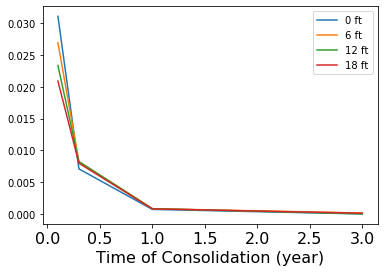

In [213]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import interp1d
y1=np.array((norm1[1],norm2[1],0.000707919,0))
tim=np.array((time))
y2=np.array((norm1[2],norm2[2],0.000822258,0.000141885))
y3=np.array((norm1[3],norm2[3],0.000821487,0.000016749))
y4=np.array((norm1[4],norm2[4],0.000797118,0.000113378))
plt.plot(tim,y1,label='0 ft')
plt.plot(tim,y2,label='6 ft')
plt.plot(tim,y3,label='12 ft')
plt.plot(tim,y4,label='18 ft')
plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
plt.legend()
plt.xlabel('Time of Consolidation (year)',fontsize=16)
plt.savefig('proj3 depth.png', bbox_inches='tight', dpi=600)
plt.show()

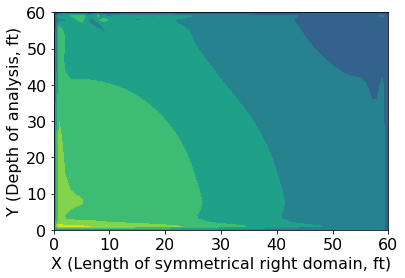

In [78]:
#plotting meshgrid
# mean_stress=(stress[0,:]+stress[1,:]+stress[2,:])/3
# mean_stress=mean_stress.reshape(tot_el,1)
# C=(stress[0,:]+stress[1,:])*0.5
# c_1=abs((stress[0,:]-stress[1,:])*0.5)
# c_2=(stress[2,:])**2
# R=np.sqrt(c_1+c_2)
# sigma_1=C+R
# sigma_2=stress[1,:]
# sigma_3=C-R
# a=1
# oc=(1/3)*np.sqrt((sigma_1-sigma_2)**2+(sigma_2-sigma_3)**2 + (sigma_3-sigma_1)**2)
# pore_p=oc*a
# pore_p=pore_p.reshape(tot_el,1)
x=np.arange(0,row,1)
y=np.flip(np.arange(0,col,1))
X, Y=np.meshgrid(x,y)
Z=p_f
# Z=np.transpose(mean_stress.reshape(row-1,col-1))
# Z=np.transpose(stress[1,:].reshape(row-1,col-1))
CS = plt.contourf(X, Y, Z, alpha= 1)
nm, lbl = CS.legend_elements()
# lbl[0]='$0.09$'
# lbl[1]='$0.075$'
# lbl[2]='$0.06$'
# lbl[3]='$0.045$'
# lbl[4]='$0.03$'
# lbl[5]='$0.015$'
# lbl[6]='$0$'
# # lbl[7]='$57613.168$'
# # lbl[8]='$57613.165$'
# lbl=lbl[::-1]
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('X (Length of symmetrical right domain, ft)',fontsize=16)
plt.ylabel('Y (Depth of analysis, ft)',fontsize=16)
plt.savefig('proj3 3 years.png', bbox_inches='tight', dpi=600)
plt.show()

In [98]:
import pandas
# pandas.DataFrame(p_t).to_csv('t_1.csv')
pandas.DataFrame(p_f1).to_csv('pf.csv')

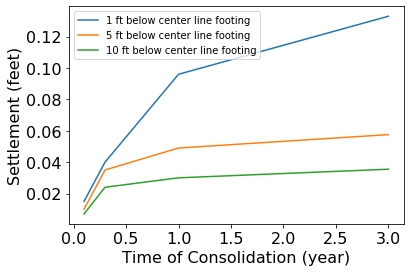

In [217]:
disp=np.array((0.015,0.040,0.096,0.133)) #1 ft
disp1=np.array((0.010,0.035,0.049,0.057552)) # 5 ft
disp2=np.array((0.007,0.024,0.030,0.0355)) # 10 ft
plt.plot(tim,disp,label='1 ft below center line footing')
plt.plot(tim,disp1,label='5 ft below center line footing')
plt.plot(tim,disp2,label='10 ft below center line footing')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.ylabel('Settlement (feet)',fontsize=16)
plt.xlabel('Time of Consolidation (year)',fontsize=16)
plt.savefig('proj3 settlement.png', bbox_inches='tight', dpi=600)
plt.show()